The goal of this notebook is to perform a thorough analysis of training strategies and model assessment through cross-validation and train-val-test splitting, and boostrapping and bagging, random forest, linear regression, etc. It will also aid in visualizing model performance through learning curves, accuracy, and loss across training rounds.

In [1]:
# load in the necessary packages

import pandas as pd
from datetime import datetime
import xarray as xr
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
##First load in the relevant files. These should be saved on your local host and downloded from the Google Drive in the README file.
# Install the necessary packages if you haven't already. 
#We will be working with only cloud brightness and shortwave radiation.
import os
import xarray as xr
data_dir = "C:/Users/kathe/OneDrive/Documents/CloudFraction/"
files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".nc")]

combined_dataset_goes = xr.open_mfdataset(
    files,
    combine='by_coords'  # Aligns by coordinates (time, lat, lon)
)



In [3]:
combined_dataset_goes

ImportError: Dask diagnostics requirements are not installed.

Please either conda or pip install as follows:

  conda install dask                     # either conda install
  python -m pip install "dask[diagnostics]" --upgrade  # or python -m pip install

<xarray.Dataset> Size: 4MB
Dimensions:              (time: 30, latitude: 41, longitude: 81)
Coordinates:
  * time                 (time) int64 240B 92 93 94 95 96 ... 118 119 120 121
  * latitude             (latitude) float64 328B 20.0 20.25 20.5 ... 29.75 30.0
  * longitude            (longitude) float64 648B -65.0 -64.75 ... -45.25 -45.0
Data variables:
    CloudOpticalDepth    (time, latitude, longitude) float64 797kB dask.array<chunksize=(30, 41, 81), meta=np.ndarray>
    CloudTopTemperature  (time, latitude, longitude) float64 797kB dask.array<chunksize=(30, 41, 81), meta=np.ndarray>
    DownwardSW           (time, latitude, longitude) float64 797kB dask.array<chunksize=(30, 41, 81), meta=np.ndarray>
    ReflectedSW          (time, latitude, longitude) float64 797kB dask.array<chunksize=(30, 41, 81), meta=np.ndarray>
    TotalPrecipWater     (time, latitude, longitude) float64 797kB dask.array<chunksize=(30, 41, 81), meta=np.ndarray>
Attributes:
    title:        Cloud Optical De

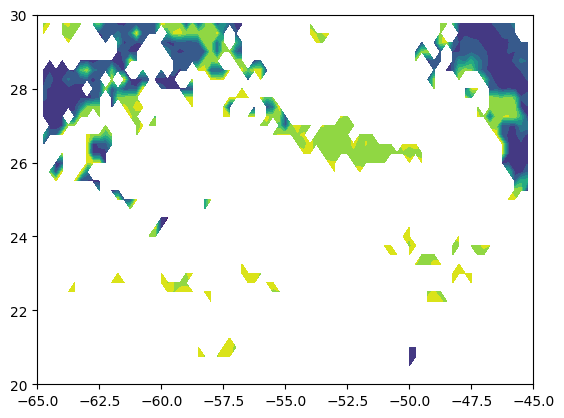

In [4]:
plt.contourf(combined_dataset_goes.longitude.values, combined_dataset_goes.latitude.values, combined_dataset_goes.CloudTopTemperature[0,:,:].values)

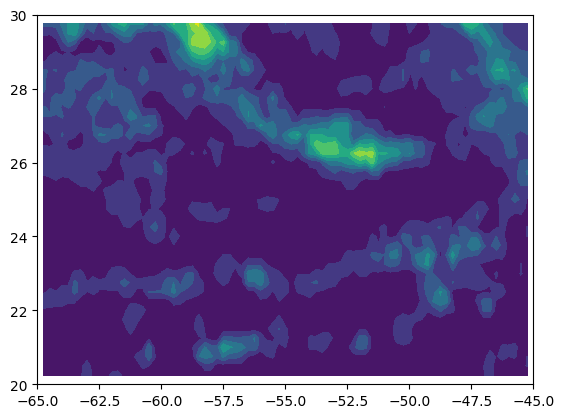

In [5]:
plt.contourf(combined_dataset_goes.longitude.values, combined_dataset_goes.latitude.values, combined_dataset_goes.ReflectedSW[0,:,:].values)


In [6]:
# get the era5 data as well

dir = "C:/Users/kathe/OneDrive/Documents/ERA5/"

# Load your dataset
ds_era5 = xr.open_dataset(dir + "era5_single_levels.nc")

# 1. Subset the dataset for April 2020
ds_era5_april_2020 = ds_era5.sel(
    valid_time=(ds_era5['valid_time.year'] == 2020) & (ds_era5['valid_time.month'] == 4)
)

# 2. Subset for the time 15:00 UTC
ds_era5_april_2020_1500 = ds_era5_april_2020.sel(
    valid_time=ds_era5_april_2020['valid_time'].dt.hour == 15
)


In [7]:
# Create the Julian days for April 2020 (92 to 121)
date_range = pd.date_range("2020-04-01", "2020-04-30", freq="D")
julian_days = [date.dayofyear for date in date_range]  # Getting Julian days 92 to 121

# Create a new 'time' variable with Julian days
ds_era5_april_2020_1500.coords['time'] = ('valid_time', julian_days)

# Now, we can drop the 'valid_time' dimension and rename the new 'time' dimension
ds_era5_april_2020_1500 = ds_era5_april_2020_1500.drop('valid_time')

# Now, all variables will have 'time', 'lat', and 'lon' dimensions
ds_era5_april_2020_1500 = ds_era5_april_2020_1500.rename({'valid_time': 'time'})

C:\Users\kathe\AppData\Local\Temp\ipykernel_14428\3298746871.py:9: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_era5_april_2020_1500 = ds_era5_april_2020_1500.drop('valid_time')
C:\Users\kathe\AppData\Local\Temp\ipykernel_14428\3298746871.py:12: UserWarning: rename 'valid_time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds_era5_april_2020_1500 = ds_era5_april_2020_1500.rename({'valid_time': 'time'})


In [8]:
ds_era5_april_2020_1500

<xarray.Dataset> Size: 4MB
Dimensions:    (latitude: 41, longitude: 81, time: 30)
Coordinates:
    number     int64 8B ...
  * latitude   (latitude) float64 328B 30.0 29.75 29.5 29.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float64 648B -65.0 -64.75 -64.5 ... -45.25 -45.0
    expver     (time) <U4 480B ...
    time       (time) int64 240B 92 93 94 95 96 97 ... 116 117 118 119 120 121
Data variables:
    u10        (time, latitude, longitude) float32 399kB ...
    v10        (time, latitude, longitude) float32 399kB ...
    t2m        (time, latitude, longitude) float32 399kB ...
    sst        (time, latitude, longitude) float32 399kB ...
    slhf       (time, latitude, longitude) float32 399kB ...
    sshf       (time, latitude, longitude) float32 399kB ...
    hcc        (time, latitude, longitude) float32 399kB ...
    lcc        (time, latitude, longitude) float32 399kB ...
    tcc        (time, latitude, longitude) float32 399kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-20T20:22 GRIB to CDM+CF via cfgrib-0.9.1...

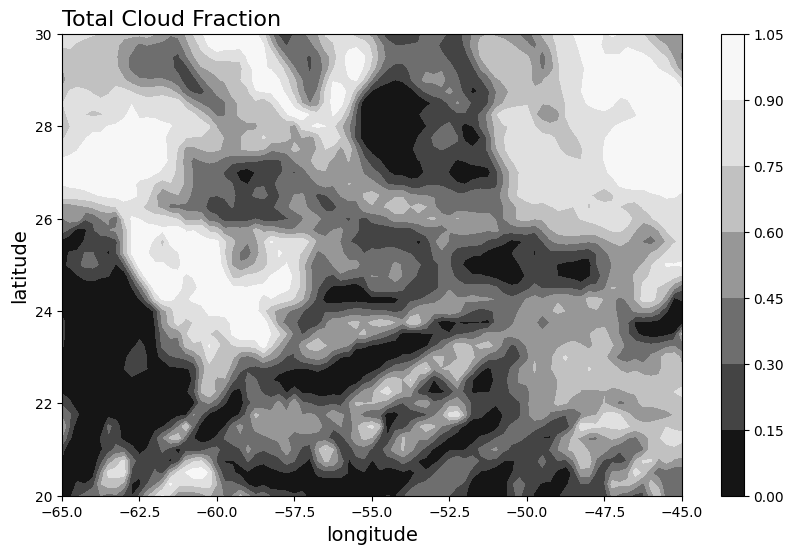

In [9]:
# plot the tcc
plt.figure(figsize=(10, 6))
plt.contourf(ds_era5_april_2020_1500.longitude.values, ds_era5_april_2020_1500.latitude.values, ds_era5_april_2020_1500.tcc[0,:,:].values, cmap='Greys_r')
plt.title("Total Cloud Fraction", loc='left', fontsize=16)
plt.ylabel("latitude", fontsize=14)
plt.xlabel("longitude", fontsize=14)
plt.colorbar()

In [10]:
# # Apply the thresholding operation to create binary values
# ds_era5_april_2020_1500['tcc'] = (ds_era5_april_2020_1500['tcc'] >= 0.5).astype("int8")  # Use "int8" for compact integer storage

# print("Binary conversion applied. The dataset has been updated.")

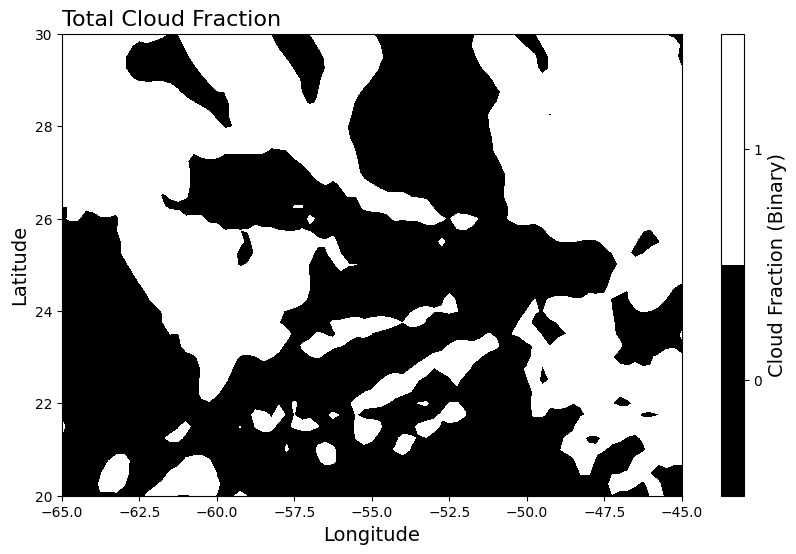

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Define a binary colormap (black for 0, white for 1)
binary_cmap = mcolors.ListedColormap(['black', 'white'])

# Plot the binary 'tcc' field
plt.figure(figsize=(10, 6))
plt.contourf(
    ds_era5_april_2020_1500.longitude.values, 
    ds_era5_april_2020_1500.latitude.values, 
    ds_era5_april_2020_1500.tcc[0, :, :].values, 
    levels=[-0.5, 0.5, 1.5],  # Define levels to ensure binary separation
    cmap=binary_cmap
)

# Add title and labels
plt.title("Total Cloud Fraction", loc='left', fontsize=16)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

# Add a discrete colorbar
colorbar = plt.colorbar(ticks=[0, 1])  # Colorbar with ticks for 0 and 1
colorbar.set_label("Cloud Fraction (Binary)", fontsize=14)

plt.show()


In [12]:
import numpy as np
from scipy.interpolate import griddata

def fill_nans_with_interpolation(ds):
    """
    Fill NaN values in the dataset using bilinear interpolation and nearest-neighbor fallback.
    """
    lat = ds.latitude.values
    lon = ds.longitude.values
    lon_flat, lat_flat = np.meshgrid(lon, lat)
    lon_flat = lon_flat.flatten()
    lat_flat = lat_flat.flatten()
    points = np.column_stack((lat_flat, lon_flat))

    for var_name in ds.data_vars:
        data = ds[var_name].values
        for time_index in range(data.shape[0]):  # Assuming time is the first dimension
            data_slice = data[time_index, :, :]
            mask = ~np.isnan(data_slice)
            valid_points = points[mask.flatten()]
            valid_values = data_slice[mask]

            # Bilinear interpolation for initial pass
            interpolated_data = griddata(valid_points, valid_values, points, method='linear')

            # Replace NaNs with bilinear interpolation
            data[time_index, :, :] = interpolated_data.reshape(data_slice.shape)

            # Fallback for remaining NaNs using nearest-neighbor interpolation
            if np.isnan(data_slice).any():
                fallback_data = griddata(valid_points, valid_values, points, method='nearest')
                fallback_data = fallback_data.reshape(data_slice.shape)
                data[time_index, :, :] = np.where(np.isnan(data[time_index, :, :]), fallback_data, data[time_index, :, :])
        
        # Update the dataset
        ds[var_name].values = data

    return ds

# Apply the function to your dataset
combined_dataset_goes_filled = fill_nans_with_interpolation(combined_dataset_goes)


Variables in ERA5 Meteorology Dataset:
['number', 'expver', 'cc', 'r', 'clwc', 't', 'u', 'v', 'w']

number=Represents the ensemble member identifier
expver=Experiment version or identifier
cc=cloud fraction
r=relative humidity (%)
clcw=cloud liquid water content
t=temperature(K)
u=wind component (m/s) E-W
v=wind component (m/s) N-S
w=vertical velocity

Variables in ERA5 Single Level Dataset:
['u10', 'v10', 't2m', 'sst', 'slhf', 'sshf', 'hcc', 'lcc', 'tcc']

u10=10-meter zonal wind component (m/s)
v10=10-meter zonal wind component (m/s)
t2m=2 meter temperature 
sst=sea surface temperature 
sshf=surface sensible heat flux W/m2
hcc=high cloud cover fraction
lcc=low cloud cover fraction
tcc=total cloud cover fraction

There is missing data. We are going to fill the missing data by taking the mean of the 3 rows surrounding empty rows of data and fill it. 

In [13]:
combined_dataset_goes_filled

<xarray.Dataset> Size: 4MB
Dimensions:              (time: 30, latitude: 41, longitude: 81)
Coordinates:
  * time                 (time) int64 240B 92 93 94 95 96 ... 118 119 120 121
  * latitude             (latitude) float64 328B 20.0 20.25 20.5 ... 29.75 30.0
  * longitude            (longitude) float64 648B -65.0 -64.75 ... -45.25 -45.0
Data variables:
    CloudOpticalDepth    (time, latitude, longitude) float64 797kB 1.914 ... ...
    CloudTopTemperature  (time, latitude, longitude) float64 797kB 295.2 ... ...
    DownwardSW           (time, latitude, longitude) float64 797kB 969.0 ... ...
    ReflectedSW          (time, latitude, longitude) float64 797kB 94.85 ... ...
    TotalPrecipWater     (time, latitude, longitude) float64 797kB 20.5 ... 3...
Attributes:
    title:        Cloud Optical Depth Remapped
    description:  Combined cloud optical depth data over time for Julian days...
    source:       GOES-16 Satellite Cloud and Moisture Imagery
    history:      Created on 2024-12-02.
    institution:  University of Washington
    references:   https://registry.opendata.aws/noaa-goes/
    time_units:   Julian days
    lat_units:    degrees_north
    lon_units:    degrees_east
    cod_units:    dimensionless

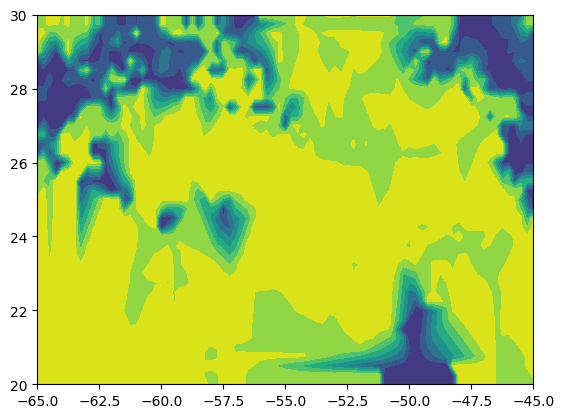

In [14]:
plt.contourf(combined_dataset_goes_filled.longitude.values, combined_dataset_goes_filled.latitude.values, combined_dataset_goes_filled.CloudTopTemperature[0,:,:].values)

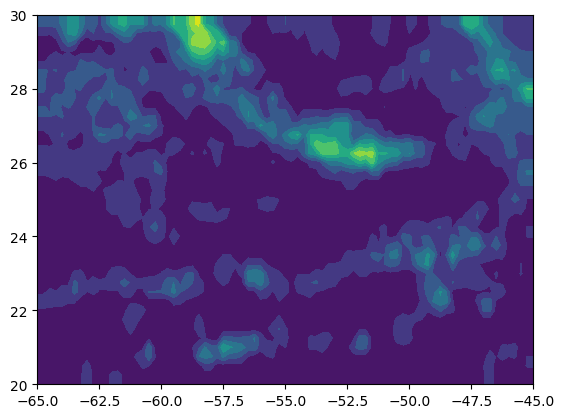

In [15]:
plt.contourf(combined_dataset_goes_filled.longitude.values, combined_dataset_goes_filled.latitude.values, combined_dataset_goes_filled.ReflectedSW[0,:,:].values)

In [16]:
combined_dataset = xr.merge([combined_dataset_goes_filled, ds_era5_april_2020_1500])

In [17]:
combined_dataset

<xarray.Dataset> Size: 8MB
Dimensions:              (time: 30, latitude: 41, longitude: 81)
Coordinates:
  * time                 (time) int64 240B 92 93 94 95 96 ... 118 119 120 121
  * latitude             (latitude) float64 328B 20.0 20.25 20.5 ... 29.75 30.0
  * longitude            (longitude) float64 648B -65.0 -64.75 ... -45.25 -45.0
    number               int64 8B ...
    expver               (time) <U4 480B ...
Data variables: (12/14)
    CloudOpticalDepth    (time, latitude, longitude) float64 797kB 1.914 ... ...
    CloudTopTemperature  (time, latitude, longitude) float64 797kB 295.2 ... ...
    DownwardSW           (time, latitude, longitude) float64 797kB 969.0 ... ...
    ReflectedSW          (time, latitude, longitude) float64 797kB 94.85 ... ...
    TotalPrecipWater     (time, latitude, longitude) float64 797kB 20.5 ... 3...
    u10                  (time, latitude, longitude) float32 399kB ...
    ...                   ...
    sst                  (time, latitude, longitude) float32 399kB ...
    slhf                 (time, latitude, longitude) float32 399kB ...
    sshf                 (time, latitude, longitude) float32 399kB ...
    hcc                  (time, latitude, longitude) float32 399kB ...
    lcc                  (time, latitude, longitude) float32 399kB ...
    tcc                  (time, latitude, longitude) float32 399kB ...
Attributes:
    title:        Cloud Optical Depth Remapped
    description:  Combined cloud optical depth data over time for Julian days...
    source:       GOES-16 Satellite Cloud and Moisture Imagery
    history:      Created on 2024-12-02.
    institution:  University of Washington
    references:   https://registry.opendata.aws/noaa-goes/
    time_units:   Julian days
    lat_units:    degrees_north
    lon_units:    degrees_east
    cod_units:    dimensionless

In [18]:
# Specify the names of the extra coordinates to be removed
extra_coords = ['number', 'expver']  # Replace with the actual coordinate names

# Drop the unwanted coordinates
cleaned_dataset = combined_dataset.drop_vars(extra_coords)

In [19]:
# List of predictor variables
variables = [
    'ReflectedSW',
    'CloudTopTemperature',
    'CloudOpticalDepth',
    't2m',
    'sst',
    'lcc',
    'hcc',
    'u10',
    'v10',
    'sshf',
    'slhf',
    'tcc',
]


# Select predictors from the xarray dataset
variables = cleaned_dataset[variables].to_array().values  # Converts to NumPy array

In [20]:
import numpy as np

# Check predictors and targets
print(f"NaN in predictors: {np.isnan(variables).any()}")
print(f"Inf in predictors: {np.isinf(variables).any()}")


NaN in predictors: False
Inf in predictors: False


In [21]:
cleaned_dataset

<xarray.Dataset> Size: 8MB
Dimensions:              (time: 30, latitude: 41, longitude: 81)
Coordinates:
  * time                 (time) int64 240B 92 93 94 95 96 ... 118 119 120 121
  * latitude             (latitude) float64 328B 20.0 20.25 20.5 ... 29.75 30.0
  * longitude            (longitude) float64 648B -65.0 -64.75 ... -45.25 -45.0
Data variables: (12/14)
    CloudOpticalDepth    (time, latitude, longitude) float64 797kB 1.914 ... ...
    CloudTopTemperature  (time, latitude, longitude) float64 797kB 295.2 ... ...
    DownwardSW           (time, latitude, longitude) float64 797kB 969.0 ... ...
    ReflectedSW          (time, latitude, longitude) float64 797kB 94.85 ... ...
    TotalPrecipWater     (time, latitude, longitude) float64 797kB 20.5 ... 3...
    u10                  (time, latitude, longitude) float32 399kB -2.308 ......
    ...                   ...
    sst                  (time, latitude, longitude) float32 399kB 299.4 ... ...
    slhf                 (time, latitude, longitude) float32 399kB -5.819e+05...
    sshf                 (time, latitude, longitude) float32 399kB -3.21e+04 ...
    hcc                  (time, latitude, longitude) float32 399kB 0.0 ... 0....
    lcc                  (time, latitude, longitude) float32 399kB 0.1067 ......
    tcc                  (time, latitude, longitude) float32 399kB 0.1067 ......
Attributes:
    title:        Cloud Optical Depth Remapped
    description:  Combined cloud optical depth data over time for Julian days...
    source:       GOES-16 Satellite Cloud and Moisture Imagery
    history:      Created on 2024-12-02.
    institution:  University of Washington
    references:   https://registry.opendata.aws/noaa-goes/
    time_units:   Julian days
    lat_units:    degrees_north
    lon_units:    degrees_east
    cod_units:    dimensionless

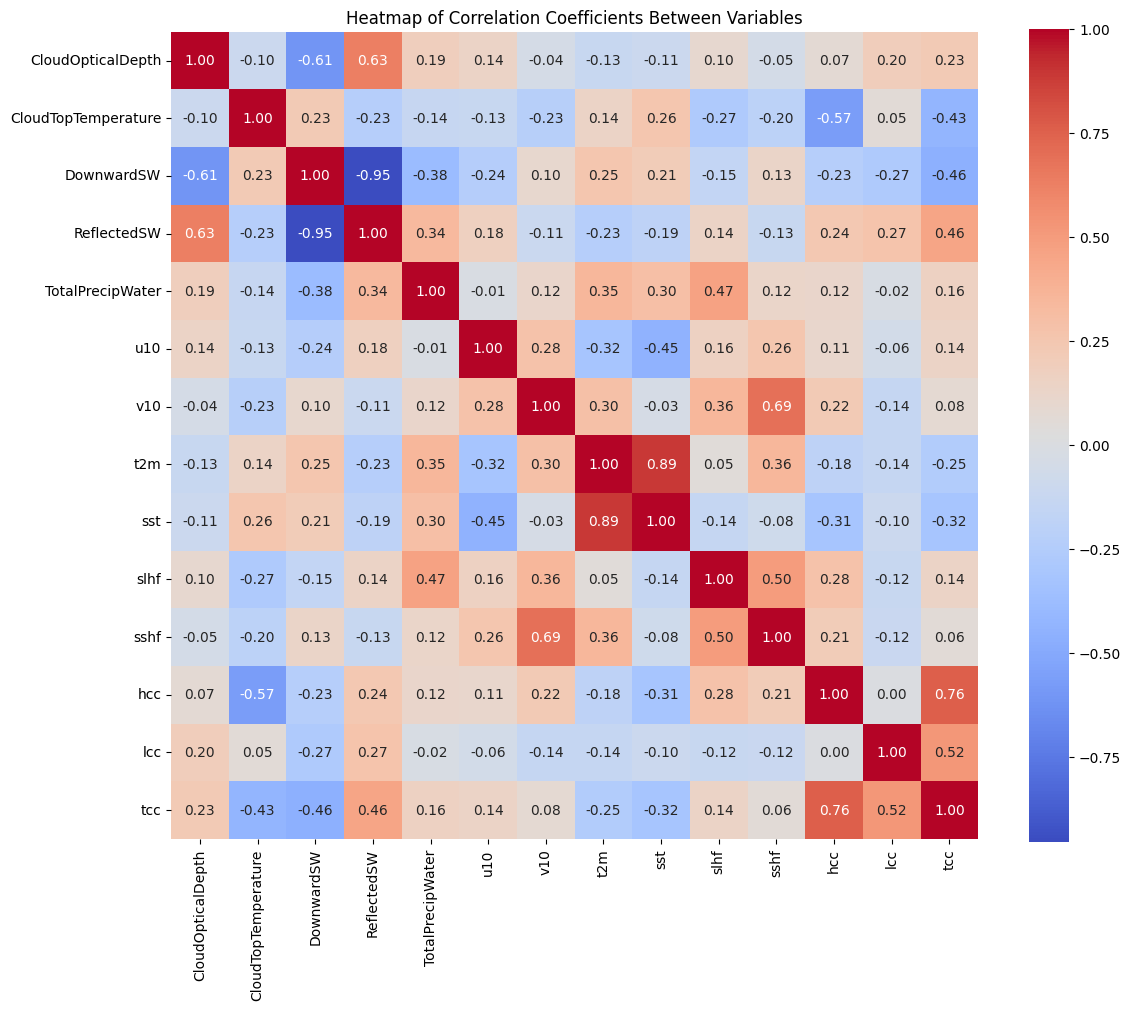

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming combined_dataset is your xarray.Dataset
# Convert the dataset to a Pandas DataFrame and drop missing values
df = cleaned_dataset.to_dataframe().dropna()

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,        # Show correlation coefficients
    fmt=".2f",         # Format coefficients with 2 decimal points
    cmap="coolwarm",   # Color map for heatmap
    cbar=True,         # Show color bar
    square=True        # Make cells square
)
plt.title("Heatmap of Correlation Coefficients Between Variables")
plt.tight_layout()
plt.show()


In [35]:
features = cleaned_dataset[['ReflectedSW', 'CloudOpticalDepth', 'CloudTopTemperature', 
                       'sst', 'slhf', 'sshf', 'u10', 'v10', 't2m'] ]


In [36]:
cleaned_dataset

<xarray.Dataset> Size: 8MB
Dimensions:              (time: 30, latitude: 41, longitude: 81)
Coordinates:
  * time                 (time) int64 240B 92 93 94 95 96 ... 118 119 120 121
  * latitude             (latitude) float64 328B 20.0 20.25 20.5 ... 29.75 30.0
  * longitude            (longitude) float64 648B -65.0 -64.75 ... -45.25 -45.0
Data variables: (12/14)
    CloudOpticalDepth    (time, latitude, longitude) float64 797kB 1.914 ... ...
    CloudTopTemperature  (time, latitude, longitude) float64 797kB 295.2 ... ...
    DownwardSW           (time, latitude, longitude) float64 797kB 969.0 ... ...
    ReflectedSW          (time, latitude, longitude) float64 797kB 94.85 ... ...
    TotalPrecipWater     (time, latitude, longitude) float64 797kB 20.5 ... 3...
    u10                  (time, latitude, longitude) float32 399kB -2.308 ......
    ...                   ...
    sst                  (time, latitude, longitude) float32 399kB 299.4 ... ...
    slhf                 (time, latitude, longitude) float32 399kB -5.819e+05...
    sshf                 (time, latitude, longitude) float32 399kB -3.21e+04 ...
    hcc                  (time, latitude, longitude) float32 399kB 0.0 ... 0....
    lcc                  (time, latitude, longitude) float32 399kB 0.1067 ......
    tcc                  (time, latitude, longitude) float32 399kB 0.1067 ......
Attributes:
    title:        Cloud Optical Depth Remapped
    description:  Combined cloud optical depth data over time for Julian days...
    source:       GOES-16 Satellite Cloud and Moisture Imagery
    history:      Created on 2024-12-02.
    institution:  University of Washington
    references:   https://registry.opendata.aws/noaa-goes/
    time_units:   Julian days
    lat_units:    degrees_north
    lon_units:    degrees_east
    cod_units:    dimensionless

Now that the dataset is ready to go. We need to begin training the model on the first 20 days of April, before we can test the model on the last 10 days of April. 

First we need to cluster the data because we expect unique clusters based on the data along with meaningful subgroups or patterns. First try K-means clustering. 

In [37]:
# Convert xarray.Dataset to pandas.DataFrame
cleaned_df = cleaned_dataset.to_dataframe()

# Reset index to flatten multi-index (time, latitude, longitude)
cleaned_df = cleaned_df.reset_index()

# Check the converted DataFrame
print(cleaned_df.head())


   time  latitude  longitude  CloudOpticalDepth  CloudTopTemperature  \
0    92      20.0     -65.00           1.914137           295.229392   
1    92      20.0     -64.75           1.914137           295.229392   
2    92      20.0     -64.50           1.914137           295.229392   
3    92      20.0     -64.25           1.914137           295.229392   
4    92      20.0     -64.00           1.914137           297.072181   

   DownwardSW  ReflectedSW  TotalPrecipWater       u10       v10         t2m  \
0  968.991272    94.846626         20.500919 -2.308136  5.337372  298.194946   
1  968.991272    94.846626         20.500919 -2.402863  5.214325  298.208618   
2  971.245972    90.849220         20.572002 -2.381378  5.078583  298.191040   
3  973.500671    91.077358         20.633780 -2.357941  4.896942  298.151978   
4  966.141449    92.485874         20.741588 -2.378448  4.748505  298.099243   

          sst      slhf     sshf  hcc       lcc       tcc  
0  299.359375 -581897.0 -3

In [38]:
if 'time' in cleaned_df.index.names or 'latitude' in cleaned_df.index.names or 'longitude' in cleaned_df.index.names:
    cleaned_df = cleaned_df.reset_index()  

In [39]:
from sklearn.cluster import KMeans

# Select features for clustering (excluding time, latitude, longitude)
clustering_features = cleaned_df.drop(columns=['time', 'latitude', 'longitude'])

# Perform clustering (choose an appropriate number of clusters, e.g., 3)
kmeans = KMeans(n_clusters=3, random_state=42)
cleaned_df['Cluster'] = kmeans.fit_predict(clustering_features)

# Print cluster assignments
print(cleaned_df['Cluster'].value_counts())


Cluster
0    43004
1    38695
2    17931
Name: count, dtype: int64


In [40]:
# Access cluster centroids
centroids = kmeans.cluster_centers_
print("Cluster Centroids:")
print(pd.DataFrame(centroids, columns=clustering_features.columns))


Cluster Centroids:
   CloudOpticalDepth  CloudTopTemperature  DownwardSW  ReflectedSW  \
0           4.716432           274.784915  898.092322   177.751676   
1           6.618891           263.506341  845.034682   215.951553   
2           4.553184           280.411700  898.140938   176.697141   

   TotalPrecipWater       u10       v10         t2m         sst  \
0         27.386365 -1.398452  1.499088  296.603279  297.545187   
1         31.044289  0.257339  2.806325  296.462358  297.016519   
2         24.296123 -2.155823 -0.378759  296.223593  297.435801   

            slhf          sshf       hcc       lcc       tcc  
0 -481306.154129 -28657.003510  0.174860  0.248486  0.416261  
1 -257037.546990 -13095.385056  0.311493  0.228780  0.509729  
2 -744541.671905 -47511.905492  0.100667  0.311076  0.421426  


Cluster
0    43004
1    38695
2    17931
Name: count, dtype: int64
Cluster Centroids:
   CloudOpticalDepth  CloudTopTemperature  DownwardSW  ReflectedSW  \
0           4.716432           274.784915  898.092322   177.751676   
1           6.618891           263.506341  845.034682   215.951553   
2           4.553184           280.411700  898.140938   176.697141   

   TotalPrecipWater       u10       v10         t2m         sst  \
0         27.386365 -1.398452  1.499088  296.603279  297.545187   
1         31.044289  0.257339  2.806325  296.462358  297.016519   
2         24.296123 -2.155823 -0.378759  296.223593  297.435801   

            slhf          sshf       hcc       lcc       tcc  
0 -481306.154129 -28657.003510  0.174860  0.248486  0.416261  
1 -257037.546990 -13095.385056  0.311493  0.228780  0.509729  
2 -744541.671905 -47511.905492  0.100667  0.311076  0.421426  


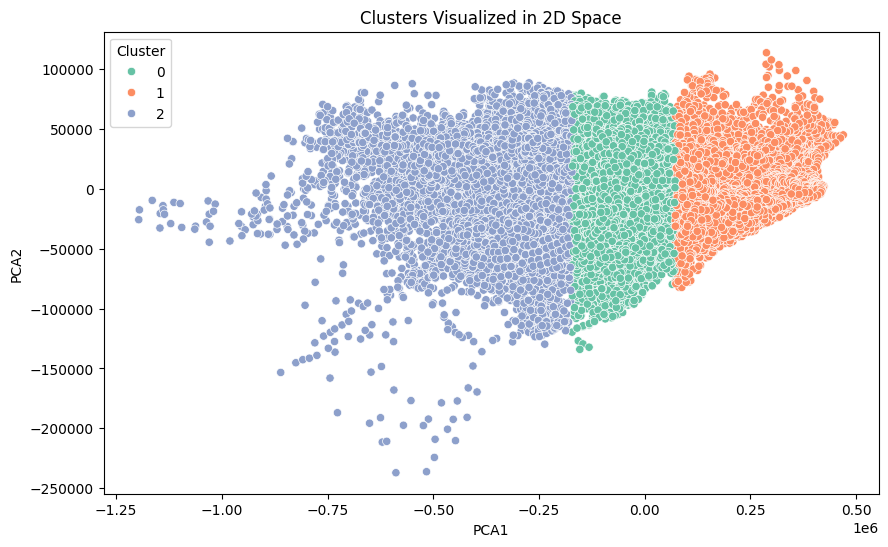

In [41]:
from sklearn.decomposition import PCA
kmeans = KMeans(n_clusters=3, random_state=42)
cleaned_df['Cluster'] = kmeans.fit_predict(clustering_features)

# Print cluster assignments
print(cleaned_df['Cluster'].value_counts())

# Print cluster centroids
centroids = kmeans.cluster_centers_
print("Cluster Centroids:")
print(pd.DataFrame(centroids, columns=clustering_features.columns))

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(clustering_features)
cleaned_df['PCA1'] = reduced_data[:, 0]
cleaned_df['PCA2'] = reduced_data[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cleaned_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title("Clusters Visualized in 2D Space")
plt.show()


In [42]:
for cluster_id in cleaned_df['Cluster'].unique():
    cluster_data = cleaned_df[cleaned_df['Cluster'] == cluster_id]
    print(f"Cluster {cluster_id} Feature Means:")
    print(cluster_data[clustering_features.columns].mean())
    print("-" * 50)


Cluster 0 Feature Means:
CloudOpticalDepth           4.718317
CloudTopTemperature       274.783041
DownwardSW                898.087800
ReflectedSW               177.762216
TotalPrecipWater           27.389082
u10                        -1.397134
v10                         1.500059
t2m                       296.603119
sst                       297.545166
slhf                  -481058.781250
sshf                   -28651.294922
hcc                         0.174810
lcc                         0.248408
tcc                         0.416197
dtype: float64
--------------------------------------------------
Cluster 1 Feature Means:
CloudOpticalDepth           6.619051
CloudTopTemperature       263.494171
DownwardSW                844.993596
ReflectedSW               215.970857
TotalPrecipWater           31.047507
u10                         0.259021
v10                         2.807725
t2m                       296.462402
sst                       297.016022
slhf                  -256930.843

In [43]:
features_cleaned=cleaned_df[['ReflectedSW', 'CloudOpticalDepth', 'CloudTopTemperature','sst', 'slhf', 'sshf', 'u10', 'v10', 't2m']]

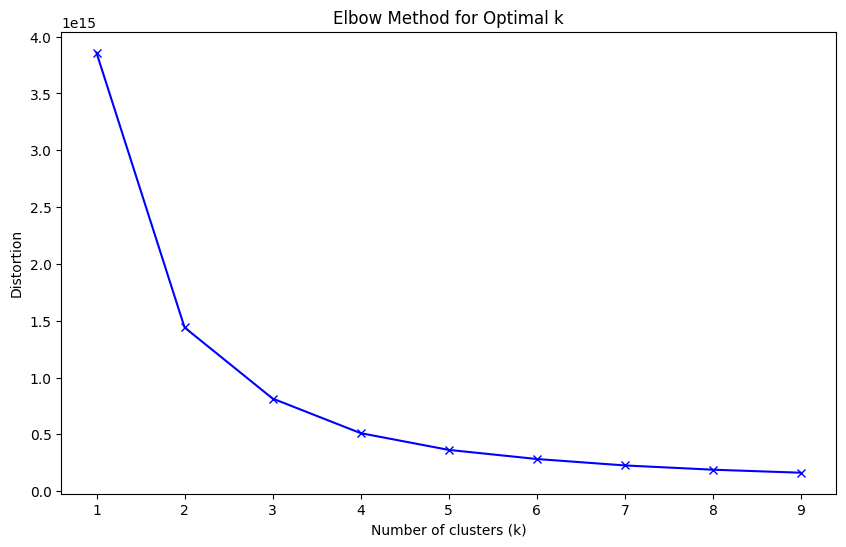

In [44]:

# Calculate distortions for a range of cluster numbers
distortions = []
K = range(1, 10)  # Adjust range as needed
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_cleaned)
    distortions.append(kmeans.inertia_)

# Plot the elbow method
plt.figure(figsize=(10, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal k')
plt.show()



In [33]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_cleaned)  # X_train should be your features before clustering



from sklearn.metrics import silhouette_score

for k in range(2, 5):  # Test different numbers of clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score for {k} clusters: {score}")



KeyboardInterrupt: 

Try nonspherical clustering. 

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=10)  # Adjust eps and min_samples as needed
dbscan_labels = dbscan.fit_predict(X_scaled)

# Check number of clusters (ignoring noise, labeled as -1)
print(f"Number of clusters (excluding noise): {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")



Number of clusters (excluding noise): 143


Try hierarchal clustering 

GMM_Cluster
1    35852
0    33527
2    30251
Name: count, dtype: int64


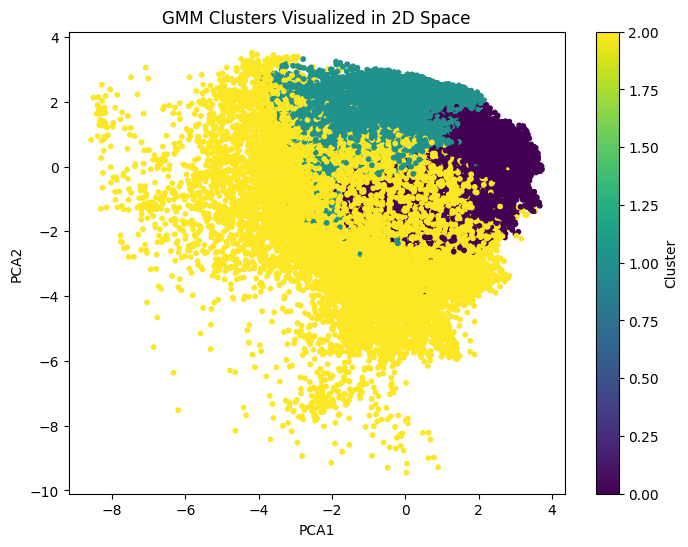

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=42)  # Adjust n_components
gmm_labels = gmm.fit_predict(X_scaled)
cleaned_df['GMM_Cluster'] = gmm_labels
print(cleaned_df['GMM_Cluster'].value_counts())
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis', s=10)
plt.title("GMM Clusters Visualized in 2D Space")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.colorbar(label="Cluster")
plt.show()



If the clustering is poor, meaning there is overlap in the clusters and they are not distinct groups, try clustering after training the model instead. 

Now split the data to begin training. 

In [45]:
cleaned_df

,time,latitude,longitude,CloudOpticalDepth,CloudTopTemperature,DownwardSW,ReflectedSW,TotalPrecipWater,u10,v10,t2m,sst,slhf,sshf,hcc,lcc,tcc,Cluster,PCA1,PCA2
0,92,20.0,-65.00,1.914137,295.229392,968.991272,94.846626,20.500919,-2.308136,5.337372,298.194946,299.359375,-581897.0,-32102.0,0.000000,0.106659,0.106659,0,-140604.736340,4061.295660
1,92,20.0,-64.75,1.914137,295.229392,968.991272,94.846626,20.500919,-2.402863,5.214325,298.208618,299.250977,-572425.0,-28006.0,0.000000,0.105591,0.105591,0,-130861.498917,7462.073729
2,92,20.0,-64.50,1.914137,295.229392,971.245972,90.849220,20.572002,-2.381378,5.078583,298.191040,299.208984,-565257.0,-26342.0,0.000000,0.283539,0.283539,0,-123591.990054,8603.725951
3,92,20.0,-64.25,1.914137,295.229392,973.500671,91.077358,20.633780,-2.357941,4.896942,298.151978,299.208008,-555401.0,-26406.0,0.000000,0.344452,0.344452,0,-113766.385398,7827.643757
4,92,20.0,-64.00,1.914137,297.072181,966.141449,92.485874,20.741588,-2.378448,4.748505,298.099243,299.202148,-548105.0,-27110.0,0.000000,0.428955,0.428955,0,-106540.336463,6598.219282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99625,121,30.0,-46.00,39.897472,269.659459,397.020432,635.815582,32.226237,7.099609,-5.035065,293.960938,295.815186,-401684.0,-62608.0,0.439087,0.947540,0.967529,0,36932.638253,-39389.816251
99626,121,30.0,-45.75,23.944380,279.241879,277.819305,615.332596,32.226237,8.330078,-2.153229,294.195312,295.703857,-366420.0,-51856.0,0.449097,0.967529,0.977539,1,72881.457123,-31214.513436
99627,121,30.0,-45.50,5.421057,231.670096,375.743927,512.868088,32.226237,9.213867,0.090912,294.423828,295.630615,-329684.0,-44496.0,0.507996,0.956848,0.980408,1,110053.265051,-26528.230471
99628,121,30.0,-45.25,3.777805,231.560535,473.668549,523.660095,32.226237,9.666016,2.407318,294.546875,295.712646,-337364.0,-48592.0,0.531982,0.717041,0.868500,1,102097.330539,-30058.357686


In [46]:
# Sort the data by time (Julian days)
cleaned_df = cleaned_df.sort_values(by='time')

# Split the data into training and testing based on Julian days
# Adjust the numbers to match the desired Julian day range
train_data = cleaned_df[cleaned_df['time'] < 112]  # First 19 days (Julian days 92 to 111)
test_data = cleaned_df[cleaned_df['time'] >= 112]  # Last 10 days (Julian days 112 to 121)

# Further split the training data into training and validation sets
from sklearn.model_selection import train_test_split
train_val_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Print details of the splits
print("Training data time range (Julian days):", train_data['time'].min(), "to", train_data['time'].max())
print("Training data size:", train_data.shape)
print("Validation data time range (Julian days):", val_data['time'].min(), "to", val_data['time'].max())
print("Validation data size:", val_data.shape)
print("Test data time range (Julian days):", test_data['time'].min(), "to", test_data['time'].max())
print("Test data size:", test_data.shape)



Training data time range (Julian days): 92 to 111
Training data size: (66420, 20)
Validation data time range (Julian days): 92 to 111
Validation data size: (6642, 20)
Test data time range (Julian days): 112 to 121
Test data size: (33210, 20)


We need to scale the data now using our cluster feature. 

In [47]:
feature_columns = ['ReflectedSW', 'CloudOpticalDepth', 'CloudTopTemperature', 
                    'sst', 'slhf', 'sshf', 'u10', 'v10', 't2m']

# Split features for training, validation, and testing
X_train = train_data[feature_columns]
X_val = val_data[feature_columns]
X_test = test_data[feature_columns]


In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on the training data and transform all sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Perform some quick exploratory data analysis, like scatter plots and histrograms just to visualize the data. 

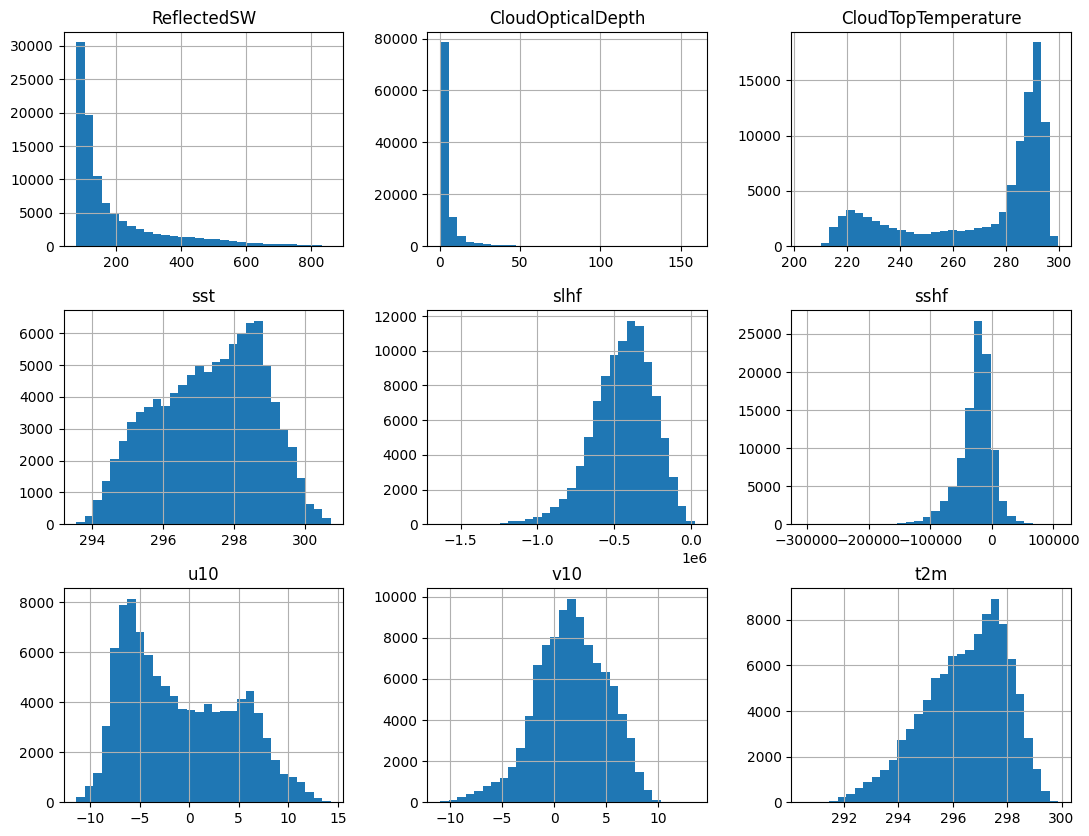

In [49]:
features_cleaned.hist(figsize=(13, 10), bins=30)
plt.show()


Begin RandomForest

In [50]:
features_cleaned = ['ReflectedSW', 'CloudOpticalDepth', 'CloudTopTemperature', 
                      'sst', 'slhf', 'sshf', 'u10', 'v10', 't2m'] 

X_train = train_data[features_cleaned]
y_train = train_data['tcc']  # Target variable
X_val = val_data[features_cleaned]
y_val = val_data['tcc']
X_test = test_data[features_cleaned]
y_test = test_data['tcc']


In [51]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [52]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_train_scaled, y_train)


RandomForestRegressor(random_state=42)

In [53]:
from sklearn.metrics import mean_squared_error, r2_score

# Validation
y_val_pred = rf.predict(X_val_scaled)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
print(f"Validation MSE: {val_mse}")
print(f"Validation R²: {val_r2}")

# Testing
y_test_pred = rf.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Test MSE: {test_mse}")
print(f"Test R²: {test_r2}")


Validation MSE: 0.0027353304771697627
Validation R²: 0.9704265650391464
Test MSE: 0.08178111993440822
Test R²: 0.2481422170523916


Show feature importance 

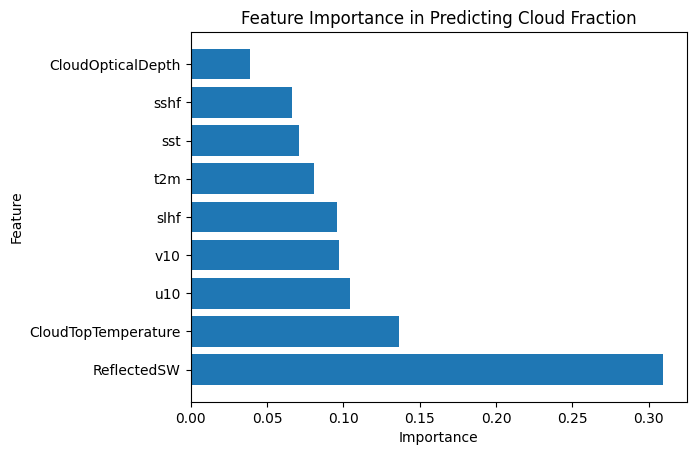

In [54]:

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': features_cleaned,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Predicting Cloud Fraction")
plt.show()


Examine distributional shifts in the data over the month long time period. 

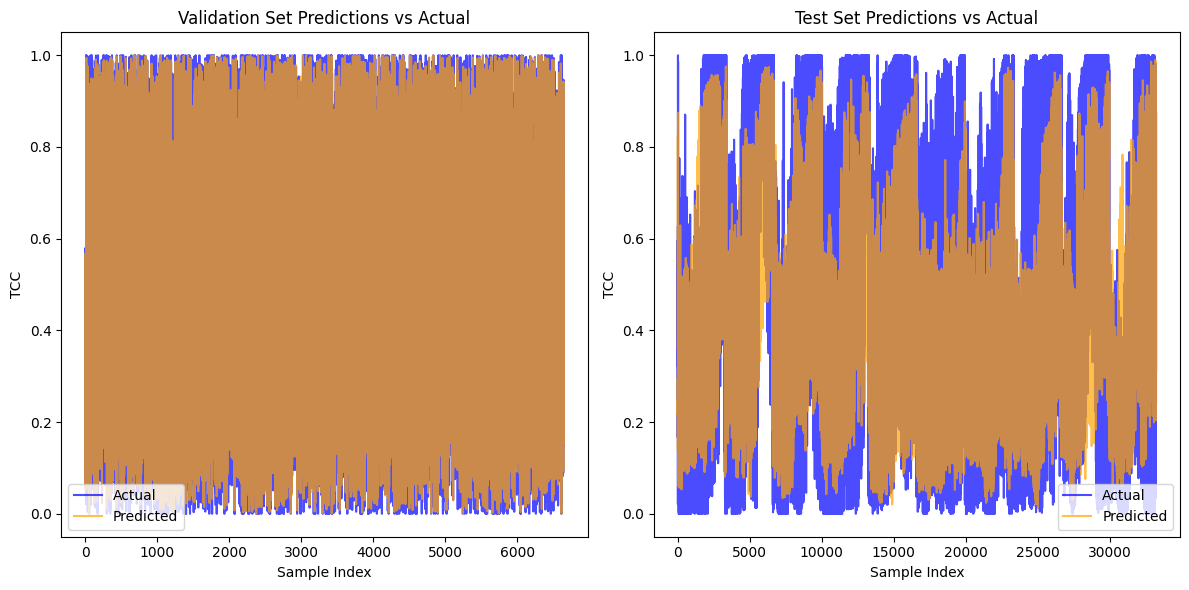

In [55]:

# Plot validation set predictions vs actual
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Two plots side by side
plt.plot(range(len(y_val)), y_val, label='Actual', color='blue', alpha=0.7)
plt.plot(range(len(y_val)), y_val_pred, label='Predicted', color='orange', alpha=0.7)
plt.title('Validation Set Predictions vs Actual')
plt.xlabel('Sample Index')
plt.ylabel('TCC')
plt.legend()

# Plot test set predictions vs actual
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label='Actual', color='blue', alpha=0.7)
plt.plot(range(len(y_test)), y_test_pred, label='Predicted', color='orange', alpha=0.7)
plt.title('Test Set Predictions vs Actual')
plt.xlabel('Sample Index')
plt.ylabel('TCC')
plt.legend()

plt.tight_layout()
plt.show()


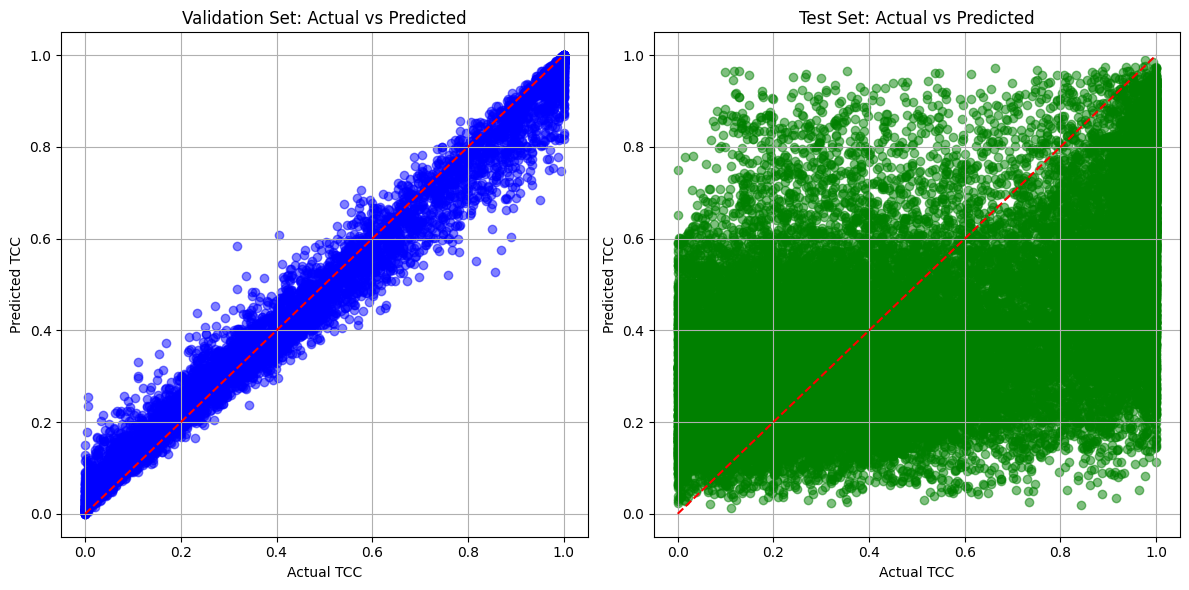

In [56]:

# Scatter plot for validation set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_val, y_val_pred, alpha=0.5, color='blue')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')
plt.title('Validation Set: Actual vs Predicted')
plt.xlabel('Actual TCC')
plt.ylabel('Predicted TCC')
plt.grid(True)

# Scatter plot for test set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5, color='green')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Actual TCC')
plt.ylabel('Predicted TCC')
plt.grid(True)

plt.tight_layout()
plt.show()


Tune the RandomForest model if the peaks for cloud fraction do not match for test and train. 

In [57]:
from sklearn.ensemble import RandomForestClassifier


In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define parameter grid for regression
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV for RandomForestRegressor
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='r2',  # Use a regression scoring metric
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Output best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best CV R² Score:", grid_search.best_score_)

# Train final model with best parameters
best_rf = grid_search.best_estimator_

# Validate the model
y_val_pred = best_rf.predict(X_val_scaled)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
print(f"\nValidation MSE: {val_mse}")
print(f"Validation R²: {val_r2}")

# Test the model
y_test_pred = best_rf.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"\nTest MSE: {test_mse}")
print(f"Test R²: {test_r2}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits


KeyboardInterrupt: 

In [ ]:
# Predict on validation and test sets using the tuned model
y_val_pred = best_rf.predict(X_val_scaled)
y_test_pred = best_rf.predict(X_test_scaled)



In [ ]:

# Validation set evaluation
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
print(f"Tuned Model Validation MSE: {val_mse}")
print(f"Tuned Model Validation R²: {val_r2}")

# Test set evaluation
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Tuned Model Test MSE: {test_mse}")
print(f"Tuned Model Test R²: {test_r2}")


Tuned Model Validation MSE: 0.05118858954041204
Tuned Model Validation R²: 0.7786452804004201
Tuned Model Test MSE: 0.02195121951219512
Tuned Model Test R²: 0.9105956448298196


Since the metrics are worse, the hyperparameter tuning over complicated the model. Do not use this. 

Try clustering, using 3 clusters before training the model. 

In [60]:
from sklearn.cluster import KMeans

# Perform clustering (as an example, KMeans)
kmeans = KMeans(n_clusters=3, random_state=42)
cleaned_df['Cluster'] = kmeans.fit_predict(cleaned_df[['ReflectedSW', 'CloudOpticalDepth', 'CloudTopTemperature', 
                                                      'sst', 'slhf', 'sshf', 'u10', 'v10', 't2m']])


In [61]:
features_columns = ['ReflectedSW', 'CloudOpticalDepth', 'CloudTopTemperature', 
                    'sst', 'slhf', 'sshf', 'Cluster', 'u10', 'v10', 't2m']

# Split features for training, validation, and testing
X_train = train_data[features_columns]
X_val = val_data[features_columns]
X_test = test_data[features_columns]

In [62]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on the training data and transform all sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [63]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_train_scaled, y_train)



RandomForestRegressor(random_state=42)

In [64]:
from sklearn.metrics import mean_squared_error, r2_score

# Validation
y_val_pred = rf.predict(X_val_scaled)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
print(f"Validation MSE: {val_mse}")
print(f"Validation R²: {val_r2}")

# Testing
y_test_pred = rf.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Test MSE: {test_mse}")
print(f"Test R²: {test_r2}")


Validation MSE: 0.0027343083836584136
Validation R²: 0.9704376155561623
Test MSE: 0.08175215815169003
Test R²: 0.24840847828435042


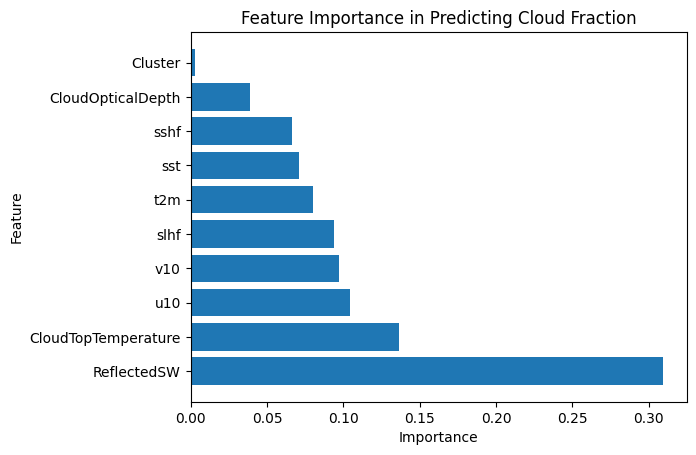

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Predicting Cloud Fraction")
plt.show()


We need to try clustering again, but this time after we've already trained the model. 

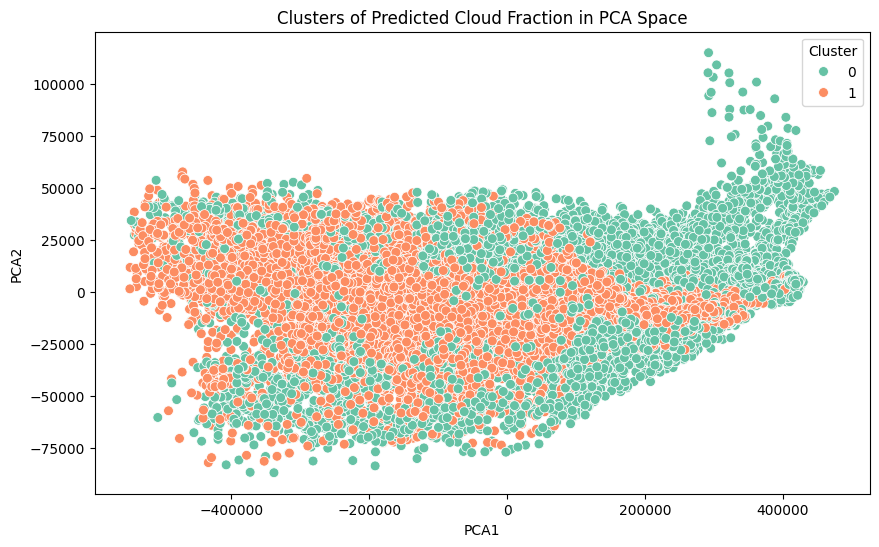

         PredictedCloudFraction  ReflectedSW  CloudOpticalDepth  \
Cluster                                                           
0                      0.650694   239.257574           5.864824   
1                      0.295908   140.384379           3.347932   

         CloudTopTemperature         sst          slhf          sshf  \
Cluster                                                                
0                 247.034596  296.888641 -356862.06250 -16314.978516   
1                 277.519096  298.277008 -490259.53125 -28277.988281   

              u10       v10         t2m          PCA1         PCA2  
Cluster                                                             
0       -0.968290  2.945291  296.340240  90144.458077  2524.839336  
1       -4.580301  1.616717  297.353821 -43735.844805 -1224.989131  


In [67]:
from sklearn.cluster import KMeans


# Step 1: Obtain predictions from the original Random Forest model
# Assuming `y_test_pred` and `X_test` are already available
predicted_results = pd.DataFrame({'PredictedCloudFraction': y_test_pred})
predicted_results = pd.concat([predicted_results, X_test.reset_index(drop=True)], axis=1)

# Step 2: Apply KMeans clustering
n_clusters = 2  # You can adjust this based on your data
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
predicted_results['Cluster'] = kmeans.fit_predict(predicted_results[['PredictedCloudFraction']])

# Step 3: Visualize clusters
pca = PCA(n_components=2)
pca_results = pca.fit_transform(predicted_results[['PredictedCloudFraction'] + list(X_test.columns)])
predicted_results['PCA1'] = pca_results[:, 0]
predicted_results['PCA2'] = pca_results[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=predicted_results, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=50)
plt.title('Clusters of Predicted Cloud Fraction in PCA Space')
plt.show()

# Step 4: Analyze clusters
cluster_summary = predicted_results.groupby('Cluster').mean()
print(cluster_summary)


Principal component analysis can reduce dimensionality. We can add this in and then retrain and run a linear regression model to see if it improves. 

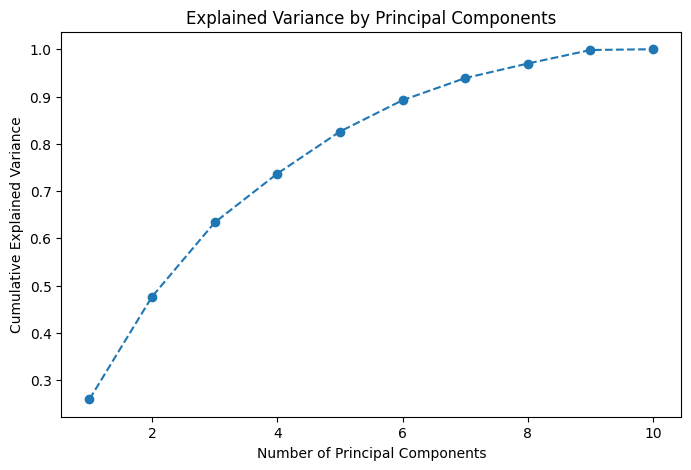

In [68]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA on the scaled feature set
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Plot explained variance ratio to choose the number of components
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.show()


In [69]:
n_components = 3
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train the model
lr = LinearRegression()
lr.fit(X_train_pca, y_train)

# Predict on the test set
y_test_pca_pred = lr.predict(X_test_pca)

# Evaluate performance
test_mse_pca = mean_squared_error(y_test, y_test_pca_pred)
test_r2_pca = r2_score(y_test, y_test_pca_pred)

print(f"Linear Regression (PCA) Test MSE: {test_mse_pca}")
print(f"Linear Regression (PCA) Test R²: {test_r2_pca}")


Linear Regression (PCA) Test MSE: 0.08815727904787693
Linear Regression (PCA) Test R²: 0.18952275991339995


In [72]:
# components = pd.DataFrame(pca.components_, columns=feature_columns)
# print(components)


Try the PCA on the RandomForest. 

In [73]:
# Apply PCA to the feature set
pca = PCA(n_components=3)  # Use 3 components as decided earlier
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train a Random Forest on the PCA-transformed features
rf_pca = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10)
rf_pca.fit(X_train_pca, y_train)

# Make predictions
y_val_pred_pca = rf_pca.predict(X_val_pca)
y_test_pred_pca = rf_pca.predict(X_test_pca)

# Evaluate performance
val_mse_pca = mean_squared_error(y_val, y_val_pred_pca)
val_r2_pca = r2_score(y_val, y_val_pred_pca)
test_mse_pca = mean_squared_error(y_test, y_test_pred_pca)
test_r2_pca = r2_score(y_test, y_test_pred_pca)

print(f"PCA + Random Forest Validation MSE: {val_mse_pca}")
print(f"PCA + Random Forest Validation R²: {val_r2_pca}")
print(f"PCA + Random Forest Test MSE: {test_mse_pca}")
print(f"PCA + Random Forest Test R²: {test_r2_pca}")


PCA + Random Forest Validation MSE: 0.04838435213840847
PCA + Random Forest Validation R²: 0.4768853332235018
PCA + Random Forest Test MSE: 0.0859149152078171
PCA + Random Forest Test R²: 0.21013801569250234


RandomForest with PCA is worse than RandomForest without PCA. 

Let's try creating a U net 

In [97]:
import numpy as np

feature_columns = ['ReflectedSW', 'CloudOpticalDepth', 'CloudTopTemperature', 
                   'sst', 'slhf', 'sshf', 'u10', 'v10', 't2m']

# Assume merged_df contains 'latitude', 'longitude', and 'time'
data_grid = cleaned_df.pivot_table(index=['latitude', 'longitude'], 
                                  columns='time', 
                                  values=feature_columns)



In [98]:

# Example dimensions
latitudes = cleaned_df['latitude'].unique()
longitudes = cleaned_df['longitude'].unique()
time_steps = cleaned_df['time'].unique()

# Initialize empty grid
tcc_grid = np.empty((len(latitudes), len(longitudes), len(time_steps)))

# Populate the grid
for t, time in enumerate(time_steps):
    time_slice = cleaned_df[cleaned_df['time'] == time]
    for i, lat in enumerate(latitudes):
        for j, lon in enumerate(longitudes):
            value = time_slice[
                (time_slice['latitude'] == lat) & (time_slice['longitude'] == lon)
            ]['tcc']
            tcc_grid[i, j, t] = value.values[0] if not value.empty else np.nan


In [99]:
print("tcc_grid type:", type(tcc_grid))
print("tcc_grid shape:", tcc_grid.shape)


tcc_grid type: <class 'numpy.ndarray'>
tcc_grid shape: (41, 81, 30)


In [100]:
tcc_grid = np.where(tcc_grid < 0.5, 0, 1)  # Binarize the grid
print("Unique values in tcc_grid after binarization:", np.unique(tcc_grid))


Unique values in tcc_grid after binarization: [0 1]


In [101]:
train_data = tcc_grid[:, :, :19]  # First 19 days
test_data = tcc_grid[:, :, 19:]  # Last 10 days
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (41, 81, 19)
Test data shape: (41, 81, 11)


In [102]:
import numpy as np

# Reshape data for U-Net
X_train = train_data.transpose(2, 0, 1)[..., np.newaxis]  # Shape: (19, 41, 81, 1)
X_test = test_data.transpose(2, 0, 1)[..., np.newaxis]    # Shape: (10, 41, 81, 1)

# Labels are the same
y_train = X_train.copy()  # Use X_train as labels for supervised learning
y_test = X_test.copy()    # Use X_test as labels for supervised learning

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (19, 41, 81, 1)
X_test shape: (11, 41, 81, 1)


In [103]:
import tensorflow as tf

# Resize function
def resize_grid(data, target_shape):
    return tf.image.resize(data, target_shape, method='bilinear').numpy()

# Define the target shape
target_shape = (40, 80)  # Resize to dimensions divisible by 16

# Resize training and test data
X_train_resized = np.array([resize_grid(x, target_shape) for x in X_train])
X_test_resized = np.array([resize_grid(x, target_shape) for x in X_test])

# Expand dimensions for channels
X_train_resized = X_train_resized[..., np.newaxis]
X_test_resized = X_test_resized[..., np.newaxis]

# Resize labels (if needed)
y_train_resized = np.array([resize_grid(y, target_shape) for y in y_train])
y_test_resized = np.array([resize_grid(y, target_shape) for y in y_test])

print("Resized X_train shape:", X_train_resized.shape)
print("Resized X_test shape:", X_test_resized.shape)


Resized X_train shape: (19, 40, 80, 1, 1)
Resized X_test shape: (11, 40, 80, 1, 1)


In [104]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

# Define U-Net architecture
def build_unet(input_shape):
    inputs = Input(input_shape)

    # Downsampling path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Upsampling path
    u4 = UpSampling2D((2, 2))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    return model

# Build the U-Net model
input_shape = (40, 80, 1)  # Adjust based on your resized grid
unet_model = build_unet(input_shape)
unet_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 40, 80, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 40, 80,    │        640 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 40, 80,    │     36,928 │ conv2d_22[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 20, 40,    │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 20, 40,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 20, 40,    │    147,584 │ conv2d_24[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 10, 20,    │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 10, 20,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 10, 20,    │    590,080 │ conv2d_26[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 20, 40,    │          0 │ conv2d_27[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 20, 40,    │          0 │ up_sampling2d_4[… │
│ (Concatenate)       │ 384)              │            │ conv2d_25[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 20, 40,    │    442,496 │ concatenate_4[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 20, 40,    │    147,584 │ conv2d_28[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_5     │ (None, 40, 80,    │          0 │ conv2d_29[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 40, 80,    │          0 │ up_sampling2d_5[… │
│ (Concatenate)       │ 192)              │            │ conv2d_23[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 40, 80,    │    110,656 │ concatenate_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 40, 80,    │     36,928 │ conv2d_30[0][0] 

 Total params: 1,881,985 (7.18 MB)

 Trainable params: 1,881,985 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [105]:
# # Compile the U-Net model
# unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # Suitable for binary segmentation
    metrics=['accuracy']
)


In [106]:
# Train the U-Net
history = unet_model.fit(
    X_train_resized, y_train_resized,
    validation_data=(X_test_resized, y_test_resized),
    epochs=75,  # Adjust as needed
    batch_size=4,  # Adjust based on memory constraints
    verbose=2
)


Epoch 1/75
5/5 - 3s - 655ms/step - accuracy: 0.6468 - loss: 0.7303 - val_accuracy: 0.6312 - val_loss: 0.6107
Epoch 2/75
5/5 - 1s - 169ms/step - accuracy: 0.6900 - loss: 0.5644 - val_accuracy: 0.6876 - val_loss: 0.4701
Epoch 3/75
5/5 - 1s - 176ms/step - accuracy: 0.7182 - loss: 0.4052 - val_accuracy: 0.7513 - val_loss: 0.4326
Epoch 4/75
5/5 - 1s - 177ms/step - accuracy: 0.7439 - loss: 0.3344 - val_accuracy: 0.7768 - val_loss: 0.2505
Epoch 5/75
5/5 - 1s - 178ms/step - accuracy: 0.7661 - loss: 0.2449 - val_accuracy: 0.7875 - val_loss: 0.1989
Epoch 6/75
5/5 - 2s - 344ms/step - accuracy: 0.7712 - loss: 0.2118 - val_accuracy: 0.7890 - val_loss: 0.1825
Epoch 7/75
5/5 - 3s - 636ms/step - accuracy: 0.7747 - loss: 0.1875 - val_accuracy: 0.7899 - val_loss: 0.1719
Epoch 8/75
5/5 - 2s - 402ms/step - accuracy: 0.7757 - loss: 0.1730 - val_accuracy: 0.7907 - val_loss: 0.1597
Epoch 9/75
5/5 - 2s - 432ms/step - accuracy: 0.7767 - loss: 0.1601 - val_accuracy: 0.7910 - val_loss: 0.1438
Epoch 10/75
5/5 - 2

In [107]:
# Evaluate on the test set
test_loss, test_accuracy = unet_model.evaluate(X_test_resized, y_test_resized)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7911 - loss: 0.1032
Test Loss: 0.10322025418281555
Test Accuracy: 0.7910795211791992


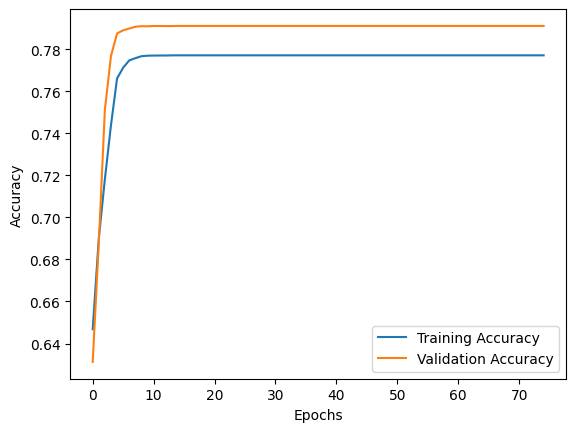

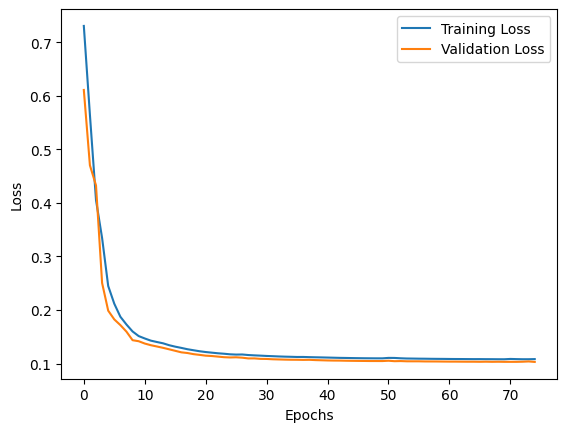

In [108]:

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


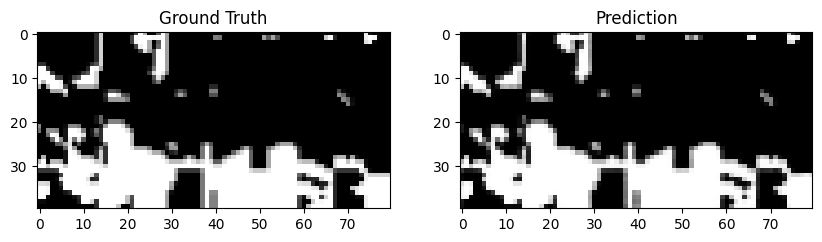

In [93]:
# Make predictions
y_pred = unet_model.predict(X_test_resized)

# Visualize predictions
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Ground Truth")
plt.imshow(y_test_resized[0, :, :, 0], cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Prediction")
plt.imshow(y_pred[0, :, :, 0], cmap='gray')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


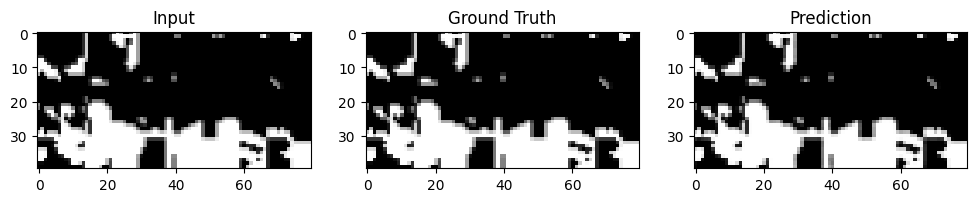

In [109]:
import matplotlib.pyplot as plt

# Get predictions
predictions = unet_model.predict(X_test_resized)

# Visualize a sample
index = 0  # Change to visualize different test samples
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.imshow(X_test_resized[index].squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(y_test_resized[index].squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(predictions[index].squeeze(), cmap='gray')
plt.show()


In [110]:
print("Prediction shape:", predictions.shape)
print("Ground truth shape:", y_test_resized.shape)


Prediction shape: (11, 40, 80, 1)
Ground truth shape: (11, 40, 80, 1)


In [111]:
print("Unique values in predictions:", np.unique(predictions))
print("Unique values in ground truth:", np.unique(y_test_resized))


Unique values in predictions: [1.8435098e-07 2.0211404e-07 2.2350554e-07 ... 9.9997342e-01 9.9997550e-01
 9.9997735e-01]
Unique values in ground truth: [0.0000000e+00 7.8105855e-05 2.3437566e-04 ... 9.9945325e-01 9.9976563e-01
 1.0000000e+00]


In [112]:
predictions_binary = (predictions >= 0.5).astype(int)


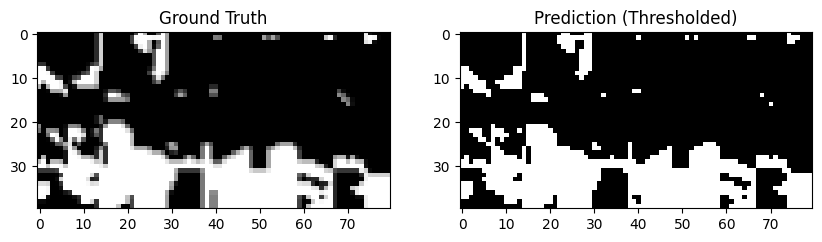

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Ground Truth")
plt.imshow(y_test_resized[0, :, :, 0], cmap="gray")
plt.subplot(1, 2, 2)
plt.title('Prediction')
plt.imshow(predictions_binary[0, :, :, 0], cmap="gray")
plt.show()


In [114]:
for i in range(len(predictions_binary)):
    accuracy = np.mean(predictions_binary[i] == y_test_resized[i])
    print(f"Image {i} accuracy: {accuracy:.2f}")


Image 0 accuracy: 0.83
Image 1 accuracy: 0.82
Image 2 accuracy: 0.81
Image 3 accuracy: 0.80
Image 4 accuracy: 0.81
Image 5 accuracy: 0.73
Image 6 accuracy: 0.75
Image 7 accuracy: 0.67
Image 8 accuracy: 0.84
Image 9 accuracy: 0.84
Image 10 accuracy: 0.81


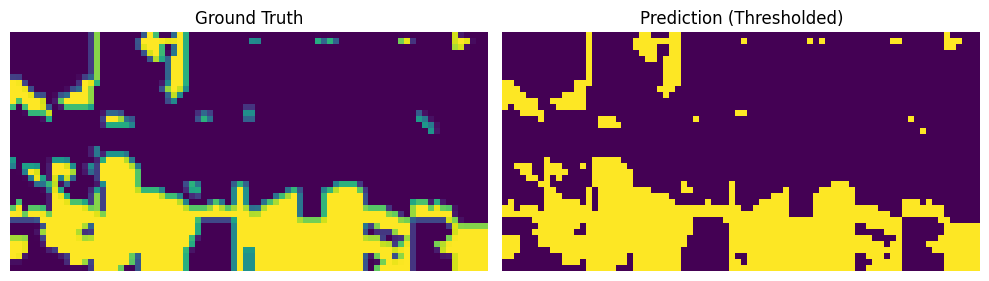

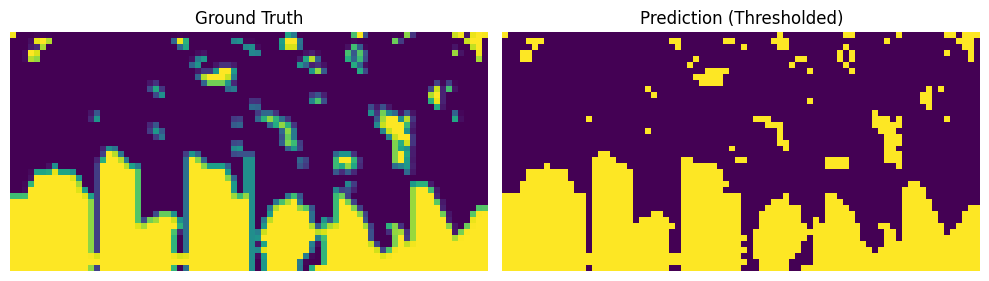

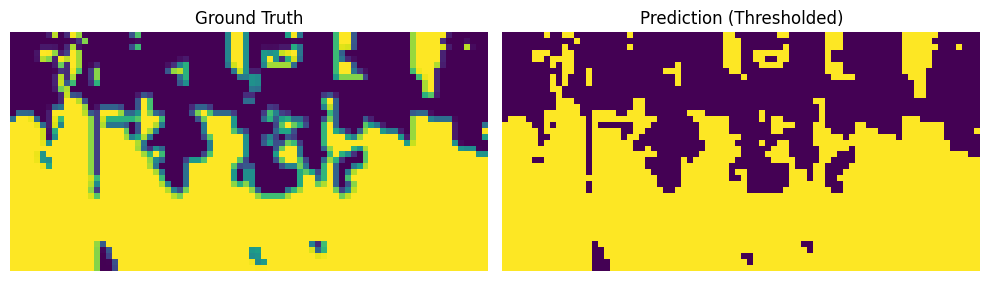

In [115]:
import matplotlib.pyplot as plt

# Define colormap for visualization
cmap = 'viridis'  # Try other options like 'plasma', 'coolwarm', or 'inferno'

# Plot the images with color
for i in range(3):  # Plot the first 3 images for example
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    
    # Ground truth
    axs[0].imshow(y_test_resized[i, :, :, 0], cmap=cmap, vmin=0, vmax=1)
    axs[0].set_title("Ground Truth")
    axs[0].axis("off")
    
    # Prediction (Thresholded)
    axs[1].imshow(predictions_binary[i, :, :, 0], cmap=cmap, vmin=0, vmax=1)
    axs[1].set_title("Prediction (Thresholded)")
    axs[1].axis("off")
    
    plt.tight_layout()
    plt.show()


In [116]:
# Evaluate on training, validation, and test sets
train_loss, train_accuracy = unet_model.evaluate(X_train_resized, y_train_resized, verbose=0)

test_loss, test_accuracy = unet_model.evaluate(X_test_resized, y_test_resized, verbose=0)

print(f"Training Loss: {train_loss}, Training Accuracy: {train_accuracy}")

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Training Loss: 0.10803110897541046, Training Accuracy: 0.7770887613296509
Test Loss: 0.10322025418281555, Test Accuracy: 0.7910795211791992
